###  Activity 2.0: Loop Ordering and False Sharing

This activity reinforces the concept of reduction and the caching principles taught in the lecture on Cilk on Sep. 18. It is recommended that you run this on the CS machines `gradx.cs.jhu.edu` or `ugradx.cs.jhu.edu`.  The results make sense here.  It is OK to run this on any machine that has at least 4 cores.  If you run on a different machine, you may end up with slightly different results. It is OK if your results don't track exactly with the expected findings. On my M1 Apple Silicon laptop the results get confusing.

**Due date**: Tuesday October 1st, 2024, 5:00 pm EDT.

**Instructions for Submission**: Submit via Gradescope.

### The Program

This is a nested loop program that counts the number of occurences of a list of tokens in an array of elements. This is a common computing pattern in data analytics. This could be used to count the number of messages sent in a network from a set of sources.

There are two serial versions of the program.  These are:
  * `countTokensElementsFirst`: loop over the larger `elements` array in the outer loop and the smaller `tokens` array in the inner loop.
  * `countTokensTokensFirst`: loop over the smaller `tokens` array in the outer loop and the larger `elements` array in the inner loop.
  
This is not a 2-d dimensional data structure like our previous examples. It is 2 separate arrays.

#### Programming


Complete the *TODO* instructions in [ebook/activities/tokens_omp/activity2_tokens.cpp](https://github.com/randalburns/pcds.2024/blob/main/ebook/activities/tokens_omp/activity2_tokens.cpp)

1. Add `parallel for` directives to functions:
   * `omp_countTokensElementsFirst`
   * `omp_countTokensTokensFirst`
2. Add `parallel for` and `reduction` directive for the array `token_counts` for:
    * `omp_countTokensElementsFirst_reduce`
    * `omp_countTokensTokensFirst_reduce`
  
The array reduction clause was added to OpenMP and requires one to specify the length of the array.  A simple example is provided in https://dvalters.github.io/optimisation/code/2016/11/06/OpenMP-array_reduction.html.

3. Unroll the loop 8 times in `unroll_omp_countTokensElementsFirst_reduce`. You may assume the the `tokens` array is evenly divisible by 8.

On the `gradx.cs.jhu.edu` machine after I added this code, I got the timing results
```
Tokens First time: 8.07097 seconds
Elements First time: 6.93468 seconds
OMP Tokens First time: 2.10465 seconds
OMP Elements First time: 1.78919 seconds
OMP Tokens First Reduce time: 1.99353 seconds
OMP Elements First Reduce time.: 1.78073 seconds
Unroll OMP Elements First Reduce time.: 0.926184 seconds
```
building with the command line
<!-- ``` -->
> g++ -O0 -fopenmp activity2_tokens.cpp
<!-- ``` -->
Compiling with `-O0` turns off all compiler optimizations to prevent the compiler from making unknown optimizations that would confound our results.

#### Questions

Provide brief but complete answers to the following questions in the following cell.

1. Why is it more efficient to iterate over the tokens in the inner loop? (Hint: Access to both arrays is sequential. This is a question of memory access patterns, cache capacity and cache misses.)

2. Of the functions `omp_countTokensElementsFirst` and `omp_countTokensTokensFirst`:




    
3. For the function that assigns different tokens to different threads, how does <b><i>false sharing</b></i> arise? Be specific about the memory access pattern or include a drawing/schema.



4. For the unrolled loop, why is it more efficient? What computations and instructions are avoided?



#### Answers

<i>Include your answers to Questions 1-4 in this cell</i>

1.  In this example, num_tokens = 128 and num_elements = 4096*256. Since `elements` is large, it cannot all be stored in the cache and as we iterate over `elements`, we will have to fetch the next chunk from memory every time we have a cache miss. Placing the `tokens` array in the inner loop will allow us to avoid repeating cache misses for the `elements` array. If the `tokens` array is placed in the outer loop, for every token, we will have to go through the `elements` array, which will cause cache misses. By the time we get to the end of the `elements` array and move to the next token, the first chunk of `elements` will have been evicted from the cache and we will have to fetch the first chunk of the `elements` array from memory again for the next token and experience the cache misses again. However, if the `tokens` array is placed in the inner loop, a chunk of the `elements` array will be loaded into the cache from the outer loop and we can count all the token for that chunk without having to incur another cache miss. Thus, having `tokens` array in the inner loop is more efficient because it causes fewer cache misses.

2.   
    a. Which function performs <b><i>sharing</i></b> in the `tokens` array?
`omp_countTokensElementsFirst` performs <b><i>sharing</i></b> in the `tokens` array because it parallelizes the loop over `elements` and there could be multiple threads try to access the same position in the `tokens` array at the same time.

   b. Which function assigns different elements of the `token_counts` array to different threads?
`omp_countTokensTokensFirst` assigns different elements of the `token_counts` array to different threads. It parallelizes the loop over the `tokens` array and each thread is assigned a different token to count in the `elements` array. Each token is counted in a single position in the `token_counts` array and each thread is assigned a different position in the `token_counts` array to write to.

3. False sharing arises when different threads are trying to access different elements of the same cache line. Since the token_counts array is relatively small, it is likely that multiple elements of the array will be stored in the same cache line. If different threads are trying to access  elements of the array, they will likely be accessing the same cache line and the cache line will have to be invalidated. The exact behavior will depend on the kind of cache being used, but if a write-back cache is being used, when a cache line is written to the cache line will have to be written back to memory and then reloaded into the cache of the core where a write is about to occur. This 'cache ping-ponging' will cause a performance hit. Thus, false sharing occurs becauses different threads are trying to access different elements of the same cache line. The following diagram illustrates false sharing:

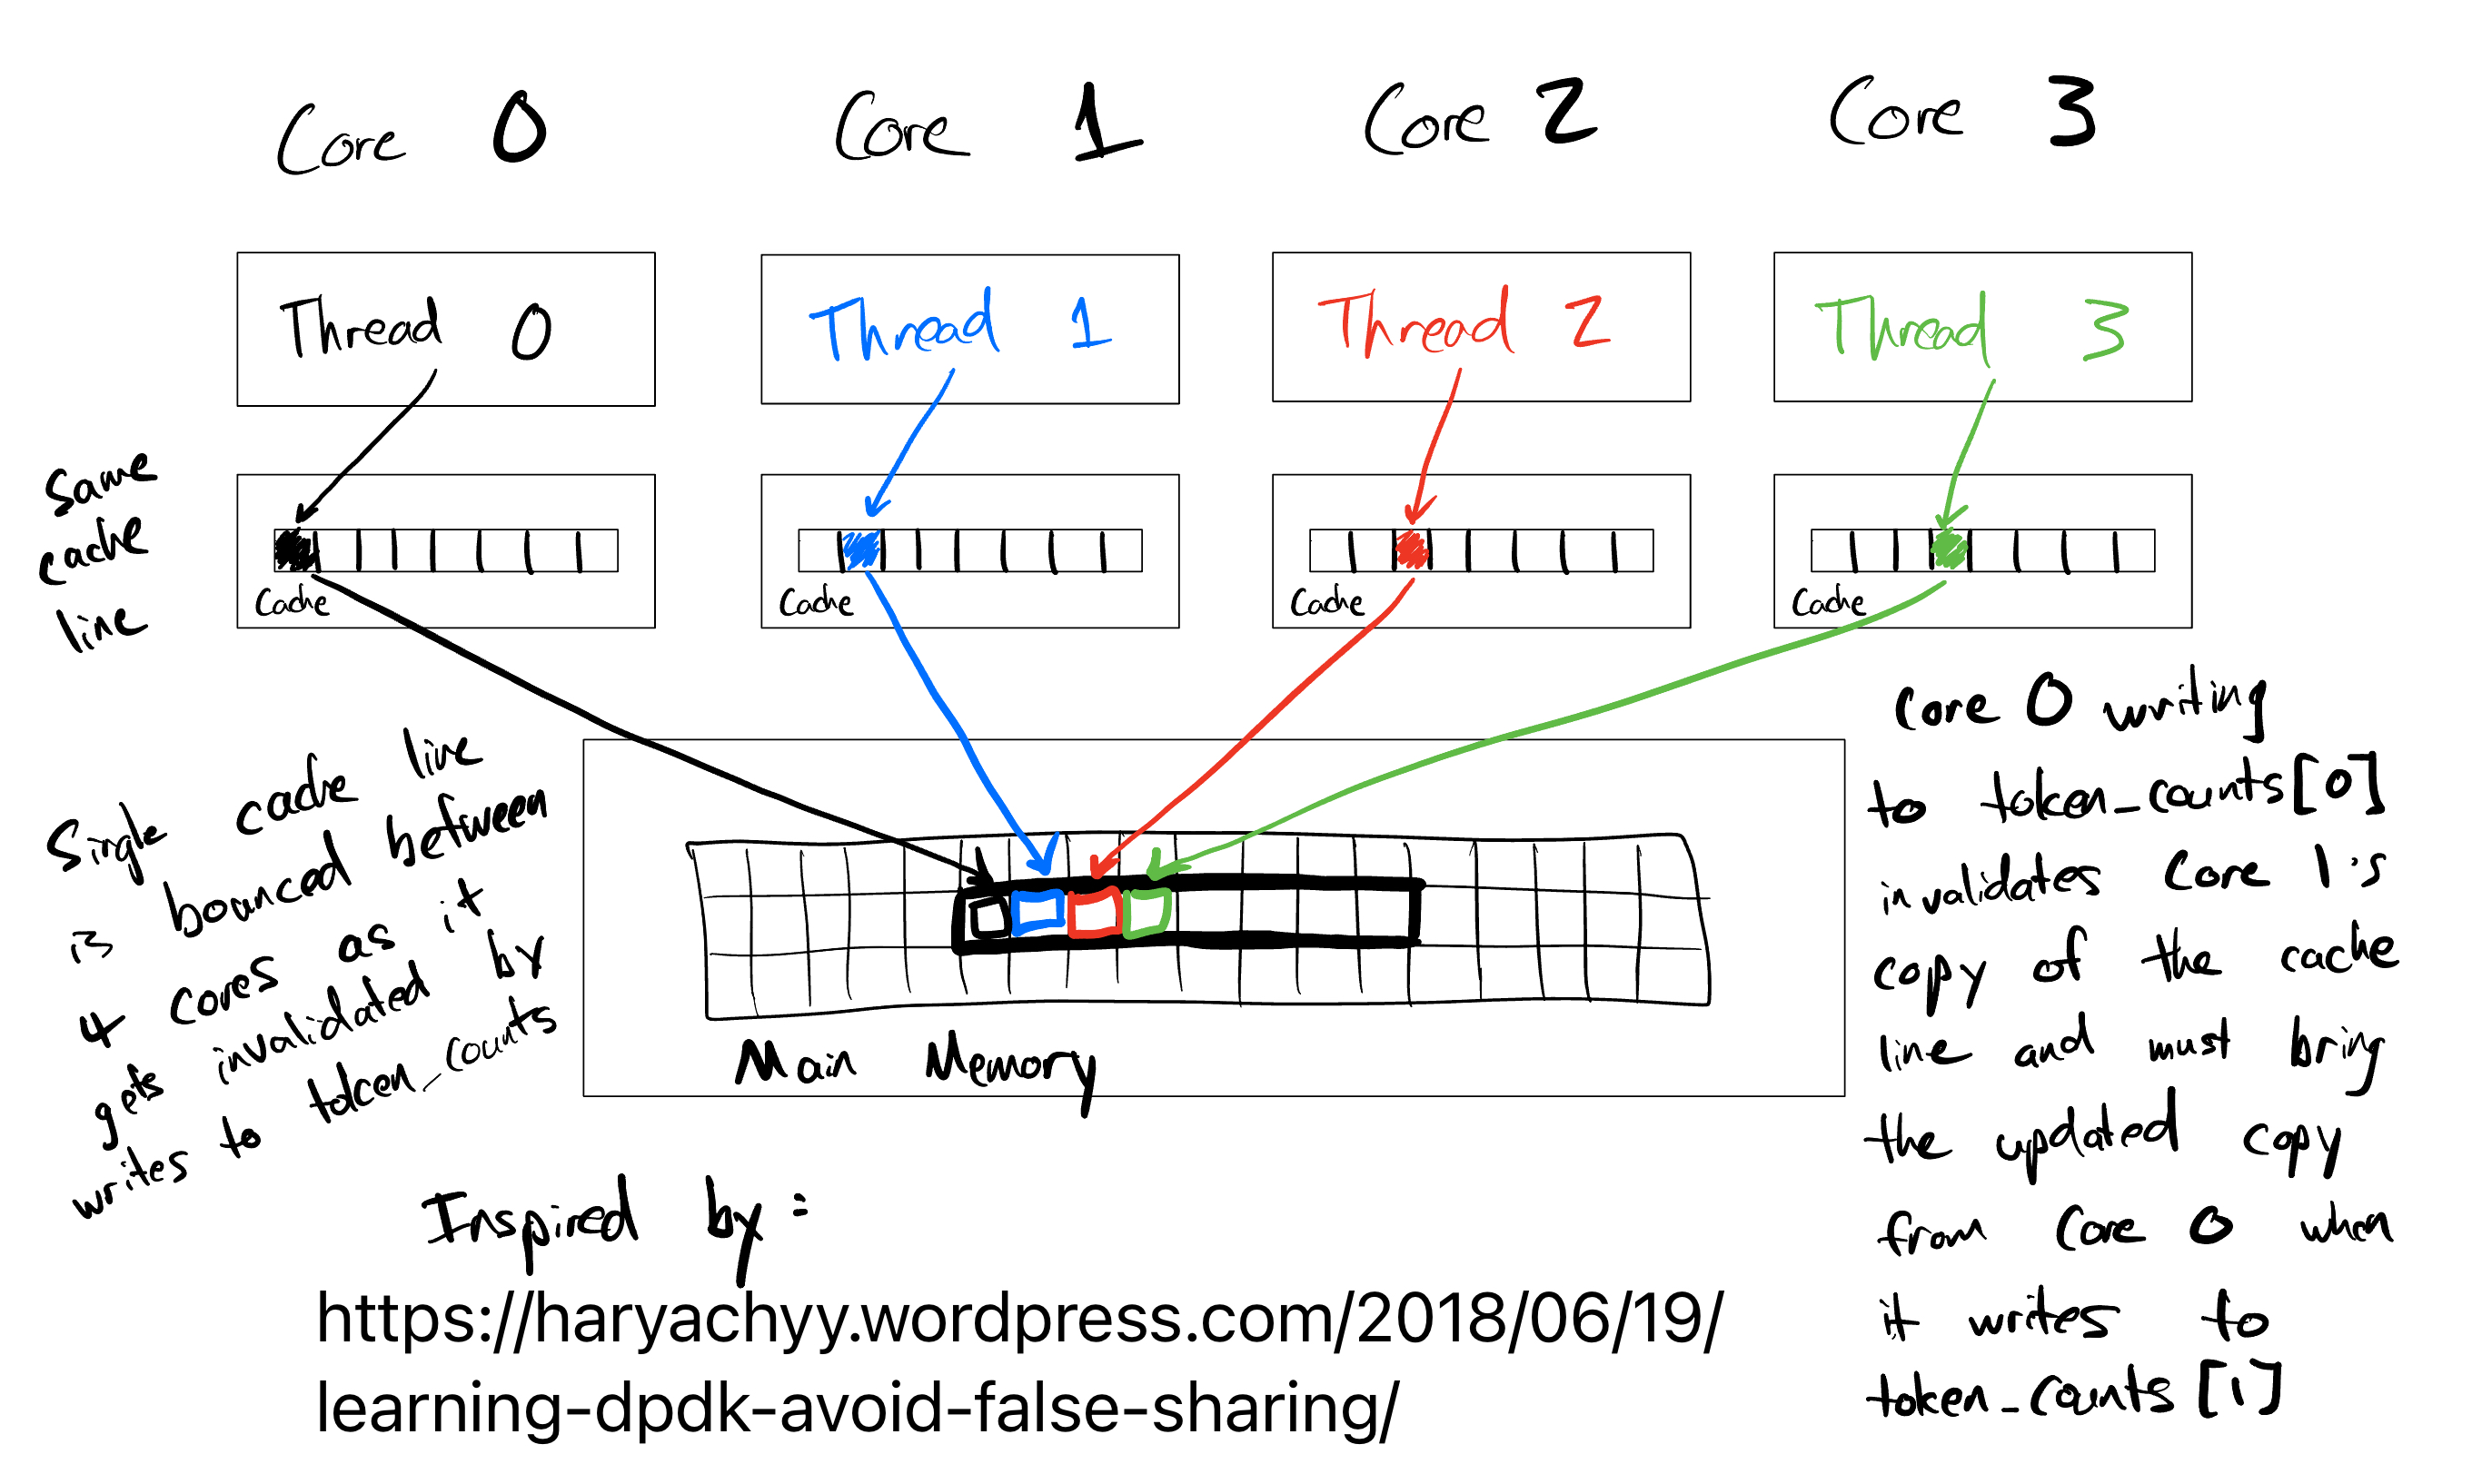

4. The unrolled loop is more efficient because it reduces the number of instructions that need to be executed. In the unrolled loop, the loop is unrolled 8 times, so the loop overhead is reduced by a factor of 8. This means that the overhead of checking the loop condition and incrementing the loop counter is reduced by a factor of 8. 


#### Code

<i>Copy-Paste your code from `activity2_tokens.cpp` to the cell below</i>

In [ ]:
#include <iostream>
#include <chrono>
#include <omp.h>

// initialize elements to random integer values 0 to range-1
void initElements (unsigned int range, unsigned int num_els, unsigned int* elements) {
    for (int i=0; i<num_els; i++)  {
        elements[i] = rand() % range;
    }
}

// initialize tokens to search.  again 0 to range-1
// note, we should probably enforce that tokens are unique. not important for performance.
void initTokens (int range, int num_toks, unsigned int* tokens) {
    for (int i=0; i<num_toks; i++)  {
        tokens[i] = rand() % range;
    }
}

// initialize all token counts to zero
void initCounts (int num_toks, unsigned int* token_counts) {
    for (int i=0; i<num_toks; i++)  {
        token_counts[i] = 0;
    }
}

// count the number of appearances of each token in the data
void countTokensElementsFirst (unsigned int num_els, unsigned int num_tokens,
                  unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    /* for all elements in the array */
    for (int el=0; el<num_els; el++) {
        /* for all tokens in the list */
        for (int tok=0; tok<num_tokens; tok++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}

// count the number of appearances of each token in the data
void countTokensTokensFirst (unsigned int num_els, unsigned int num_tokens,
                             unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    /* for all tokens in the list */
    for (int tok=0; tok<num_tokens; tok++) {
        /* for all elements in the array */
        for (int el=0; el<num_els; el++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}

// count the number of appearances of each token in the data
void omp_countTokensElementsFirst (unsigned int num_els, unsigned int num_tokens,
                  unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    //TODO parallel for
    #pragma omp parallel for
    /* for all elements in the array */
    for (int el=0; el<num_els; el++) {
        /* for all tokens in the list */
        for (int tok=0; tok<num_tokens; tok++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}

// count the number of appearances of each token in the data
void omp_countTokensTokensFirst (unsigned int num_els, unsigned int num_tokens,
                             unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    //TODO parallel for
    #pragma omp parallel for
    /* for all tokens in the list */
    for (int tok=0; tok<num_tokens; tok++) {
        /* for all elements in the array */
        for (int el=0; el<num_els; el++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}

// elements first with reduction
void omp_countTokensElementsFirst_reduce (unsigned int num_els, unsigned int num_tokens,
                             unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    //TODO parallel for reduction
    #pragma omp parallel for reduction (+: token_counts[:num_tokens])
    /* for all elements in the array */
    for (int el=0; el<num_els; el++) {
        /* for all tokens in the list */
        for (int tok=0; tok<num_tokens; tok++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}

// tokens first with reduction
void omp_countTokensTokensFirst_reduce (unsigned int num_els, unsigned int num_tokens,
                             unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    //TODO parallel for reduction
    #pragma omp parallel for reduction (+: token_counts[:num_tokens])
    /* for all tokens in the list */
    for (int tok=0; tok<num_tokens; tok++) {
        /* for all elements in the array */
        for (int el=0; el<num_els; el++) {
            /* update the count for the token */
            if (elements[el] == tokens[tok]) {
                token_counts[tok]++;
            }
        }
    }
}


// unroll tokens elements first with reduction
void unroll_omp_countTokensElementsFirst_reduce (unsigned int num_els, unsigned int num_tokens,
                             unsigned int* elements, unsigned int* tokens, unsigned int* token_counts) {

    //TODO parallel for reduction 
    #pragma omp parallel for reduction (+: token_counts[:num_tokens])
    /* for all elements in the array */
    for (int el=0; el<num_els; el++) {
        /* for all tokens in the list */
        for (int tok=0; tok<num_tokens; tok+=8) {
            //TODO unroll loop 8 times

            if (elements[el] == tokens[tok]) {  //assuming num_tokens is multiple of 8. If it is not, we need to add a check here such as if (tok+1 < num_tokens && elements[el] == tokens[tok+1])
                token_counts[tok]++;
            }
            if (elements[el] == tokens[tok+1]) {
                token_counts[tok+1]++;
            }
            if (elements[el] == tokens[tok+2]) {
                token_counts[tok+2]++;
            }
            if (elements[el] == tokens[tok+3]) {
                token_counts[tok+3]++;
            }
            if (elements[el] == tokens[tok+4]) {
                token_counts[tok+4]++;
            }
            if (elements[el] == tokens[tok+5]) {
                token_counts[tok+5]++;
            }
            if (elements[el] == tokens[tok+6]) {
                token_counts[tok+6]++;
            }
            if (elements[el] == tokens[tok+7]) {
                token_counts[tok+7]++;
            }
        }
    }
}


int main() {

    const unsigned int range = 4096;
    const unsigned int num_tokens = 128;
    const unsigned int num_elements = 4096*256;
    const unsigned int loop_iterations = 16;

    unsigned int tokens[num_tokens];
    unsigned int elements[num_elements];
    unsigned int token_counts[num_tokens];

    initElements(range, num_elements, elements);
    initTokens(range, num_tokens, tokens);
    initCounts(num_tokens, token_counts);

    omp_set_num_threads(4);

    // run once to warm the cache
    countTokensTokensFirst(num_elements, num_tokens, elements, tokens, token_counts);

    // countTokensTokensFirst
    // Start the timer
    auto start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        countTokensTokensFirst(num_elements, num_tokens, elements, tokens, token_counts);
    }
    // Stop the timer
    auto end = std::chrono::high_resolution_clock::now();
    // Calculate the duration
    std::chrono::duration<double> duration = end - start;
    // Print the duration in seconds
    std::cout << "Tokens First time: " << duration.count() << " seconds" << std::endl;

    // reset counts only works right if running one loop_iteration
    initCounts(num_tokens, token_counts);

    // run once to warm the cache
    countTokensElementsFirst(num_elements, num_tokens, elements, tokens, token_counts);
  

    // countTokensElementsFirst
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        countTokensElementsFirst(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "Elements First time: " << duration.count() << " seconds" << std::endl;

    // reset counts only works right if running one loop_iteration
    initCounts(num_tokens, token_counts);
    	
    
    // omp_countTokensTokensFirst
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        omp_countTokensTokensFirst(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "OMP Tokens First time: " << duration.count() << " seconds" << std::endl;

    // reset counts only works right if running one loop_iteration
    initCounts(num_tokens, token_counts);

    
    // omp_countTokensElementsFirst
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        omp_countTokensElementsFirst(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "OMP Elements First time: " << duration.count() << " seconds" << std::endl;

    // reset counts only works right if running one loop_iteration
    initCounts(num_tokens, token_counts);

    // omp_countTokensTokensFirst_reduce
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        omp_countTokensTokensFirst_reduce(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "OMP Tokens First Reduce time: " << duration.count() << " seconds" << std::endl;

    // omp_countTokensElementsFirst_reduce
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        omp_countTokensElementsFirst_reduce(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "OMP Elements First Reduce time.: " << duration.count() << " seconds" << std::endl;

    // reset counts only works right if running one loop_iteration
    initCounts(num_tokens, token_counts);

    // unroll_omp_countTokensElementsFirst_reduce
    start = std::chrono::high_resolution_clock::now();
    for(int j=0; j<loop_iterations; j++) {
        unroll_omp_countTokensElementsFirst_reduce(num_elements, num_tokens, elements, tokens, token_counts);
    }
    end = std::chrono::high_resolution_clock::now();
    duration = end - start;
    std::cout << "Unroll OMP Elements First Reduce time.: " << duration.count() << " seconds" << std::endl;
}
